# **Group 1**
# **Project 339 Hotel Reviews**
## **Part 2 - Model Building**

In [1]:
from os import cpu_count
import re
import pickle
import numpy as np
import pandas as pd
import json

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, StackingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import classification_report

from colorama import Fore, Style
from imblearn.over_sampling import SVMSMOTE

import spacy
import math

from plotly.subplots import make_subplots
import plotly.graph_objects as go
import matplotlib.pyplot as plt

import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('vader_lexicon')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [2]:
CPU_COUNT = cpu_count()
stop_words = stopwords.words("english")
nlp = spacy.load("en_core_web_sm")

with open('negations.json') as f:
    negations = json.load(f)

def make_string(tokens: list) -> str:
    return " ".join(tokens)

## Loading Reviews

In [3]:
reviews = pd.read_pickle('processed_reviews_with_sentiment.pkl')
reviews.head()

,Reviews,Sentiment
0,"[nice, hotel, expensive, parking, get, good, d...",Positive
1,"[ok, nothing, special, charge, diamond, member...",Positive
2,"[nice, room, not, experience, hotel, monaco, s...",Positive
3,"[unique, great, stay, wonderful, time, hotel, ...",Positive
4,"[great, stay, great, stay, go, seahawk, game, ...",Positive


## Training Doc2Vec to generate document embeddings

In [4]:
vectorizer = TfidfVectorizer(min_df=0.1, max_df=0.9, strip_accents='unicode', ngram_range=(1, 2))
text = reviews['Reviews'].apply(make_string).values
tfidf_embeddings = vectorizer.fit_transform(text)
with open('tfidf-vectorizer.pkl', 'wb') as f:
    pickle.dump(vectorizer, f)
with open('tfidf-embeddings.pkl', 'wb') as f:
    pickle.dump(tfidf_embeddings, f)

In [5]:
with open('tfidf-vectorizer.pkl', 'rb') as f:
    vectorizer = pickle.load(f)
with open('tfidf-embeddings.pkl', 'rb') as f:
    tfidf_embeddings = pickle.load(f)

## Preparing data for training classification models

In [6]:
x = tfidf_embeddings.toarray()
y = reviews['Sentiment'].apply(lambda s: 1 if s == 'Positive' else 0).values
np.unique(y, return_counts=True)

(array([0, 1], dtype=int64), array([ 1447, 19044], dtype=int64))

### Oversampling

In [7]:
svm_smote = SVMSMOTE(random_state=34)
svm_smote_result = svm_smote.fit_resample(x, y)
x_smote, y_smote = svm_smote_result[0], svm_smote_result[1]
np.unique(y_smote, return_counts=True)

(array([0, 1], dtype=int64), array([19044, 19044], dtype=int64))

## Splitting Data

In [8]:
x_train, x_test, y_train, y_test = train_test_split(x_smote, y_smote, test_size=0.3, random_state=34)

In [9]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

### Save Standard Scaler

In [10]:
with open('standard-scaler', 'wb') as f:
    pickle.dump(scaler, f)

### Load Standard Sacler

In [11]:
with open('standard-scaler', 'rb') as f:
    scaler = pickle.load(f)

## Training Different Classification Models

### **1. Logistic Regression**

Logistic Regression-
              precision    recall  f1-score   support

           0       0.92      0.95      0.93      5793
           1       0.94      0.92      0.93      5634

    accuracy                           0.93     11427
   macro avg       0.93      0.93      0.93     11427
weighted avg       0.93      0.93      0.93     11427



FileNotFoundError: [Errno 2] No such file or directory: '../Models/Sentiment-Classifier-LR.pkl'

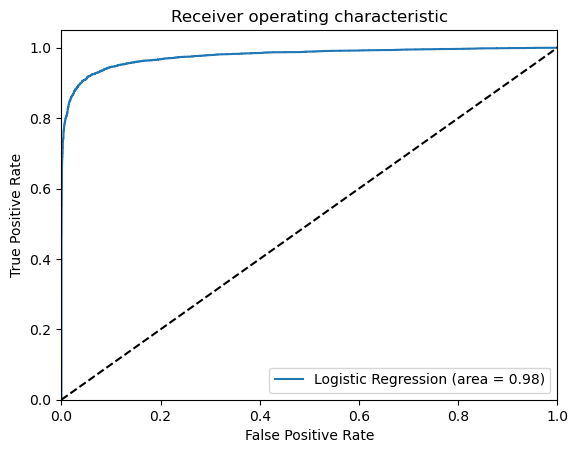

In [12]:
lgc = LogisticRegression(n_jobs=-1, random_state=34)
lgc.fit(x_train, y_train)
y_pred = lgc.predict(x_test)
y_score = lgc.predict_proba(x_test)[:, 1]
auc_score = roc_auc_score(y_test, y_score)

print(Style.RESET_ALL + Style.BRIGHT + Fore.LIGHTRED_EX + "Logistic Regression-")
print(Style.RESET_ALL + Style.BRIGHT + Fore.LIGHTBLUE_EX + f'{classification_report(y_test, y_pred)}')

fpr, tpr, thresholds = roc_curve(y_test, y_score)
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % auc_score)
plt.plot([0, 1], [0, 1], 'k--') # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

with open('../Models/Sentiment-Classifier-LR.pkl', 'wb') as f:
    pickle.dump(lgc, f)

### **2. Decision Tree**

In [ ]:
dt = DecisionTreeClassifier(criterion='gini', random_state=34)
dt.fit(x_train, y_train)
y_pred = dt.predict(x_test)
y_score = dt.predict_proba(x_test)[:, 1]
auc_score = roc_auc_score(y_test, y_score)

print(Style.RESET_ALL + Style.BRIGHT + Fore.LIGHTRED_EX + "Decision Tree-")
print(Style.RESET_ALL + Style.BRIGHT + Fore.LIGHTBLUE_EX + f'{classification_report(y_test, y_pred)}')

fpr, tpr, thresholds = roc_curve(y_test, y_score)
plt.plot(fpr, tpr, label='Decision Tree (area = %0.2f)' % auc_score)
plt.plot([0, 1], [0, 1], 'k--') # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

with open('../Models/Sentiment-Classifier-DT.pkl', 'wb') as f:
    pickle.dump(dt, f)

### **3. Random Forest**

In [ ]:
rf = RandomForestClassifier(n_estimators=100, criterion='gini', random_state=34, n_jobs=-1)
rf.fit(x_train, y_train)
y_pred = rf.predict(x_test)
y_score = rf.predict_proba(x_test)[:, 1]
auc_score = roc_auc_score(y_test, y_score)

print(Style.RESET_ALL + Style.BRIGHT + Fore.LIGHTRED_EX + "Decision Tree-")
print(Style.RESET_ALL + Style.BRIGHT + Fore.LIGHTBLUE_EX + f'{classification_report(y_test, y_pred)}')

fpr, tpr, thresholds = roc_curve(y_test, y_score)
plt.plot(fpr, tpr, label='Random Forest (area = %0.2f)' % auc_score)
plt.plot([0, 1], [0, 1], 'k--') # random predictions curve
plt.xlim([0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

with open('../Models/Sentiment-Classifier-RF.pkl', 'wb') as f:
    pickle.dump(rf, f)

### **4. AdaBoost**

In [ ]:
adb = AdaBoostClassifier(algorithm='SAMME.R', learning_rate=1, n_estimators=50, random_state=34)
adb.fit(x_train, y_train)
y_pred = adb.predict(x_test)
y_score = adb.predict_proba(x_test)[:, 1]
auc_score = roc_auc_score(y_test, y_score)

print(Style.RESET_ALL + Style.BRIGHT + Fore.LIGHTRED_EX + "AdaBoost-")
print(Style.RESET_ALL + Style.BRIGHT + Fore.LIGHTBLUE_EX + f'{classification_report(y_test, y_pred)}')

fpr, tpr, thresholds = roc_curve(y_test, y_score)
plt.plot(fpr, tpr, label='AdaBoost (area = %0.2f)' % auc_score)
plt.plot([0, 1], [0, 1], 'k--') # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

with open('../Models/Sentiment-Classifier-ADB.pkl', 'wb') as f:
    pickle.dump(adb, f)

### **4. Support Vector Machine**

In [ ]:
svc = SVC(kernel="rbf", probability=True, random_state=34)
svc.fit(x_train, y_train)
y_pred = svc.predict(x_test)
y_score = svc.predict_proba(x_test)[:, 1]
auc_score = roc_auc_score(y_test, y_score)

print(Style.RESET_ALL + Style.BRIGHT + Fore.LIGHTRED_EX + "Support Vector Machine-")
print(Style.RESET_ALL + Style.BRIGHT + Fore.LIGHTBLUE_EX + f'{classification_report(y_test, y_pred)}')

fpr, tpr, thresholds = roc_curve(y_test, y_score)
plt.plot(fpr, tpr, label='Support Vector Machine (area = %0.2f)' % auc_score)
plt.plot([0, 1], [0, 1], 'k--') # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

with open('../Models/Sentiment-Classifier-SVC.pkl', 'wb') as f:
    pickle.dump(svc, f)

### **5. KNN**

In [ ]:
knn = KNeighborsClassifier(n_neighbors=3, p=2, n_jobs=-1)
knn.fit(x_train, y_train)
y_pred = knn.predict(x_test)
y_score = knn.predict_proba(x_test)[:, 1]
auc_score = roc_auc_score(y_test, y_score)

print(Style.RESET_ALL + Style.BRIGHT + Fore.LIGHTRED_EX + "KNN-")
print(Style.RESET_ALL + Style.BRIGHT + Fore.LIGHTBLUE_EX + f'{classification_report(y_test, y_pred)}')

fpr, tpr, thresholds = roc_curve(y_test, y_score)
plt.plot(fpr, tpr, label='KNN (area = %0.2f)' % auc_score)
plt.plot([0, 1], [0, 1], 'k--') # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

with open('../Models/Sentiment-Classifier-KNN.pkl', 'wb') as f:
    pickle.dump(knn, f)

### **6. Gaussian Naive Bayes**

In [ ]:
gnb = GaussianNB()
gnb.fit(x_train, y_train)
y_pred = gnb.predict(x_test)
y_score = gnb.predict_proba(x_test)[:, 1]
auc_score = roc_auc_score(y_test, y_score)

print(Style.RESET_ALL + Style.BRIGHT + Fore.LIGHTRED_EX + "Gaussian Naive Bayes-")
print(Style.RESET_ALL + Style.BRIGHT + Fore.LIGHTBLUE_EX + f'{classification_report(y_test, y_pred)}')

fpr, tpr, thresholds = roc_curve(y_test, y_score)
plt.plot(fpr, tpr, label='Gaussian Naive Bayes (area = %0.2f)' % auc_score)
plt.plot([0, 1], [0, 1], 'k--') # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

with open('../Models/Sentiment-Classifier-GNB.pkl', 'wb') as f:
    pickle.dump(gnb, f)

### **8. XGBoost**

In [ ]:
xgb = XGBClassifier(n_jobs=-1, random_state=34)
xgb.fit(x_train, y_train)
y_pred =  xgb.predict(x_test)
y_score = xgb.predict_proba(x_test)[:, 1]
auc_score = roc_auc_score(y_test, y_score)

print(Style.RESET_ALL + Style.BRIGHT + Fore.LIGHTRED_EX + "XGBoost-")
print(Style.RESET_ALL + Style.BRIGHT + Fore.LIGHTBLUE_EX + f'{classification_report(y_test, y_pred)}')

fpr, tpr, thresholds = roc_curve(y_test, y_score)
plt.plot(fpr, tpr, label='XGBoost (area = %0.2f)' % auc_score)
plt.plot([0, 1], [0, 1], 'k--') # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

with open('../Models/Sentiment-Classifier-XGB.pkl', 'wb') as f:
    pickle.dump(xgb, f)

In [ ]:
accuracy_scores = dict(
    LR=0.93, 
    DT=0.92, 
    RF=0.97, 
    AdaBoost=0.92, 
    SVM=0.98, 
    KNN=0.74, 
    GNB=0.90, 
    XGBoost=0.97
)
plt.figure(dpi=200)
plt.bar(x=accuracy_scores.keys(), height=accuracy_scores.values())
plt.xlabel('Model')
plt.ylabel('Accuracy')

## Prediction For New Review

In [ ]:
def strip_leading_trailing_space(string: str) -> str:
    return string.strip()
def remove_alphanumeric(string: str) -> str:
    pattern = re.compile(r'\w*\d\w* ')
    result = pattern.sub('', string)
    return result
def add_space_after_punctuation(string: str) -> str:
    pattern = re.compile(r'(?<=[.,])(?=[^\s])')
    return pattern.sub(' ', string)
def remove_unknown(string: str) -> str:
    string = re.sub(r'__Çî__otal', '', string)
    string = re.sub(r'__Ç_é_', '', string)
    return string
def correct_spellings(string: str) -> str:
    string = re.sub(r"\b(can't)\b|\B(can't)\B", r' \1\2 ', string)
    string = re.sub(r"(?<=\s)ca n't(?=[\s.,!?])", "can't", string)
    string = re.sub(r"(?<=\s)n't(?=[\s.,!?])", "can't", string)
    string = re.sub(r'(?<=\s)n(?=[\s.,!?])', "and", string)
    string = re.sub(r'(?<=\s)u(?=[\s.,!?])', "you", string)
    return string
def remove_tokens_with_special_characters(tokens: list) -> list:
    pattern = re.compile('[^a-zA-Z0-9]')
    return [token for token in tokens if not pattern.search(token)]
def remove_tokens_with_numbers(tokens: list) -> list:
    pattern = re.compile(r'\d')
    return [token for token in tokens if not pattern.search(token)]
def lemmatize(string: str) -> list:
    lemma_arr = []
    doc = nlp(string)
    for token in doc:
        lemma_arr.append(token.lemma_)
    return lemma_arr
def to_lowercase(tokens: list) -> list:
    return [token.lower() for token in tokens]
def remove_stopwords(tokens: list) -> list:
    result = []
    for token in tokens:
        if token not in stop_words:
            result.append(token)
        elif token in stop_words and token in negations:
            result.append(token)
    return result

In [ ]:
def preprocess_review(string: str) -> list:
    string = strip_leading_trailing_space(string)
    string = remove_unknown(string)
    string = add_space_after_punctuation(string)
    string = correct_spellings(string)
    string = remove_alphanumeric(string)
    tokens = lemmatize(string)
    tokens = to_lowercase(tokens)
    tokens = remove_stopwords(tokens)
    tokens = remove_tokens_with_special_characters(tokens)
    tokens = remove_tokens_with_numbers(tokens)
    return tokens

In [ ]:
with open('Sentiment-Classifier-LR.pkl', 'rb') as f:
    LR = pickle.load(f)
with open('Sentiment-Classifier-DT.pkl', 'rb') as f:
    DT = pickle.load(f)
with open('Sentiment-Classifier-RF.pkl', 'rb') as f:
    RF = pickle.load(f)
with open('Sentiment-Classifier-KNN.pkl', 'rb') as f:
    KNN = pickle.load(f)
with open('Sentiment-Classifier-ADB.pkl', 'rb') as f:
    ADB = pickle.load(f)
with open('Sentiment-Classifier-XGB.pkl', 'rb') as f:
    XGB = pickle.load(f)
with open('Sentiment-Classifier-SVC.pkl', 'rb') as f:
    SVM = pickle.load(f)
with open('Sentiment-Classifier-GNB.pkl', 'rb') as f:
    GNB = pickle.load(f)

classifier_models = dict(
    LogisticRegression=LR, 
    DecisionTree=DT, 
    RandomForest=RF, 
    KNearestNeighbours=KNN, 
    AdaBoost=ADB, 
    XGBoost=XGB, 
    SupportVectorClassifier=SVM, 
    GaussianNaiveBayes=GNB
)

In [ ]:
new_doc = "The customer service is terrible. Communication is frustrating as it just walks you in circles and nothing gets accomplished. Claims that they work on your behalf to solve issues is unfounded. Moreover, some appeared to be flat out lies after we followed up with hotel property to confirm information provided."

analyzer = SentimentIntensityAnalyzer()
new_doc_polarity_score = analyzer.polarity_scores(new_doc)
true_label = 'Positive' if new_doc_polarity_score['compound'] >= 0 else 'Negative'

tokens = preprocess_review(new_doc)
# print(tokens)

key_words = set()
vocab = vectorizer.get_feature_names_out()
for token in tokens:
    if token in vocab:
        key_words.add(token)

# TfIdf embeddings
new_doc_embedding = vectorizer.transform([make_string(tokens)]).toarray()

features = np.array(scaler.transform(new_doc_embedding))

probabilities = []
pred_labels = []
for _, classifier in classifier_models.items():
    pred_labels.append('Positive' if classifier.predict(features)[0] == 1 else 'Negative')
    probabilities.append(classifier.predict_proba(features)[0])

# print(probabilities)

n = len(classifier_models)
n_cols = 3
n_rows = int(math.ceil(n/n_cols))
subplot_titles = []
for i, key in enumerate(classifier_models.keys()):
    subplot_titles.append(f"{key} -> {pred_labels[i]}")

fig = make_subplots(n_rows, n_cols, subplot_titles=subplot_titles)
for row in range(n_rows):
    for col in range(n_cols):
        i = n_cols*row + col
        try:
            fig.add_trace(go.Bar(x=['Negative', 'Positive'], y=probabilities[i]), row=row+1, col=col+1)
        except:
            pass
fig.update_layout(yaxis={'categoryorder':'total ascending'})
fig.update_layout(showlegend=False, height=1000, title=f'True Label = {true_label}')
fig.show()
print(key_words)